In [74]:
import numpy as np
import matplotlib.pyplot as plt

def get_data(path):
    file = open(path, "r")
    dataset = np.array([line.strip('\n').split(',') for line in file]).astype(np.float)
    classes = dataset[:,-1:].transpose()[0]
    unique, counts = np.unique(classes, return_counts=True)
    classes_bin = np.zeros(shape=(len(classes), len(unique)))
    for i in range(len(classes)):
        classes_bin[i] = np.array([(classes[i] + 1)/2, (1 - classes[i])/2])  
    return dataset, dataset[:,:-1], classes, classes_bin

def info(dataset, classes):
    print('Число признаков: ' + str(dataset.shape[1]))
    unique, counts = np.unique(classes, return_counts=True)
    print('Число классов: ' + str(len(unique)))
    print('Объем выборки: ' + str(len(classes)))
    print('Объем выборки для каждого класса: ' + str(counts))
    return

path = ".../DataLab3_var3.txt"
dataset_wide, dataset, classes, classes_bin = get_data(path)

info(dataset, classes)

Число признаков: 2
Число классов: 2
Объем выборки: 650
Объем выборки для каждого класса: [400 250]


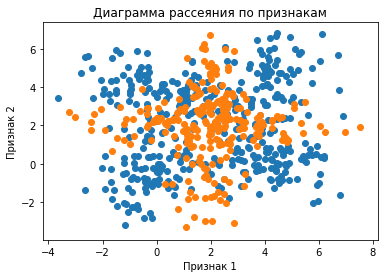

In [75]:
def index_of(element, arr, index = 0):
    res = -1
    for i in range(index, len(arr)):
        if arr[i] == element:
            res = i
    return res

def data_scatter(dataset, classes):
    unique, counts = np.unique(classes, return_counts=True)
    coordinates = []
    for i in range(len(counts)):
        coordinates.append(np.array([]))
    for i in range(len(classes)):
        if (len(coordinates[index_of(classes[i], unique)]) == 0):
            coordinates[index_of(classes[i], unique)] = np.array(dataset[i])
        else:    
            coordinates[index_of(classes[i], unique)] = np.vstack((coordinates[index_of(classes[i], unique)], (dataset[i])));
    fig, ax = plt.subplots()
    for i in range(len(unique)):
        ax.scatter(x=coordinates[i][:,:1].transpose()[0], y = coordinates[i][:,1:].transpose()[0])
    ax.set_title('Диаграмма рассеяния по признакам')
    ax.set_xlabel('Признак 1')
    ax.set_ylabel('Признак 2')
    plt.show()
    
data_scatter(dataset, classes)

In [76]:
from sklearn.model_selection import train_test_split

def get_TrainTestValid(dataset, classes, train_perc, test_perc):
    train_data, tmp_data, train_classes, tmp_classes = train_test_split(dataset, classes, test_size=(1 - train_perc))
    test_data, valid_data, test_classes, valid_classes = train_test_split(tmp_data, tmp_classes, test_size=(1 - train_perc - (1 - train_perc - test_perc))/(1 - train_perc))
    print('Объем обучающей выборки: ' + str(len(train_data)))
    print('Объем валидационной выборки: ' + str(len(valid_data)))
    print('Объем тестовой выборки: ' + str(len(test_data)))
    print()
    unique, counts = np.unique(train_classes, return_counts=True)
    print('Объемы обучающей выборки для каждого класса: ' + str(counts))
    unique, counts = np.unique(valid_classes, return_counts=True)
    print('Объемы валидационной выборки для каждого класса: ' + str(counts))
    unique, counts = np.unique(test_classes, return_counts=True)
    print('Объемы тестовой выборки для каждого класса: ' + str(counts))
    return train_data, valid_data, test_data, train_classes, valid_classes, test_classes


train_data, valid_data, test_data, train_classes, valid_classes, test_classes = get_TrainTestValid(dataset, classes, 0.6, 0.3)    

Объем обучающей выборки: 390
Объем валидационной выборки: 195
Объем тестовой выборки: 65

Объемы обучающей выборки для каждого класса: [226 164]
Объемы валидационной выборки для каждого класса: [125  70]
Объемы тестовой выборки для каждого класса: [49 16]


In [77]:
from sklearn.preprocessing import StandardScaler

def standartize(data_to_fit, data_to_transform):
    scaler = StandardScaler()
    scaler.fit(data_to_fit)
    return scaler.transform(data_to_transform)

train_data_standartized = standartize(train_data, train_data)
valid_data_standartized = standartize(train_data, valid_data)
test_data_standartized = standartize(train_data, test_data)

In [78]:
import tensorflow as tf
# import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras import optimizers
from keras import losses
from keras.callbacks import EarlyStopping
from keras import backend as K

In [79]:
classif = Sequential()

in_dim = np.shape(train_data_standartized)[1]

layer1count = 10
layer2count = 10
layer1AH = 'tanh'
layer2AH = 'tanh'

moment = 0.5

classif.add(Dense(layer1count, activation=layer1AH, input_dim=in_dim, kernel_initializer='he_normal'))
classif.add(Dense(layer2count, activation=layer2AH, kernel_initializer='he_normal'))
classif.add(Dense(1))

opti = optimizers.SGD(lr=0.001, momentum=moment, decay=0.0, nesterov=False)

classif.compile(loss='mean_squared_error', optimizer=opti, metrics=['mean_squared_error'])
classif.build()

In [80]:
b_size = len(train_data_standartized)    #или число при mini_batch, 1 или None при Stohastic

f_predict_before = classif.predict(test_data_standartized, batch_size=None, verbose=0, steps=None)

stop = EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=25000, verbose=0, restore_best_weights=False)

history = classif.fit(
    train_data_standartized, train_classes, batch_size=b_size, epochs=20000, callbacks=[stop],
    verbose=0, validation_data=(valid_data_standartized, valid_classes), shuffle=False
)

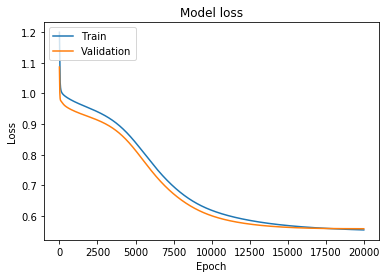

In [81]:
def show_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

show_loss(history)